### Investigation on whether I can Fill the missing values on Fore look doue to RFI with the Aft look

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '../..')))

from src.processing import windsat_datacube, create_landmask


In [2]:
windsat_folder = "../../data/raw/daily_Windsat"

# Load all data for both looks
ds = windsat_datacube(windsat_folder, look= None)
ds

<xarray.Dataset> Size: 6GB
Dimensions:         (day_number: 24, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, look_direction: 2,
                     polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number      (day_number) int32 96B 1 2 57 58 84 ... 283 323 324 348 349
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, look_direction, polarization
Data variables: (12/13)
    longitude       (day_number, longitude_grid) float32 138kB dask.array<chunksize=(1, 1440), meta=np.ndarray>
    latitude        (day_number, latitude_grid) float32 69kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    node            (day_number, swath_sector) int32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...              ...
    eaa             (day_number, frequency_band, latitude_grid, longitude_grid, look_direction, swath_sector) float32 796MB dask.array<chunksize=(1, 1, 360, 720, 1, 1), meta=np.ndarray>
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, look_direction, swath_sector) float32 796MB dask.array<chunksize=(1, 1, 360, 720, 1, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, look_direction, swath_sector) float32 2GB dask.array<chunksize=(1, 1, 1, 240, 480, 1, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, look_direction, swath_sector) int32 398MB dask.array<chunksize=(1, 360, 720, 1, 1), meta=np.ndarray>
    surtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 199MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    airtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 199MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [3]:
# Select the TbToAs, swap dims for visualiztion using cartopy
Tbs = ds.tbtoa.swap_dims(
    {
        "latitude_grid": "lat",
        "longitude_grid": "lon",
    }
)
Tbs = Tbs.sortby(['lat', 'lon'])
Tbs

<xarray.DataArray 'tbtoa' (day_number: 24, polarization: 2, frequency_band: 2,
                           lat: 720, lon: 1440, look_direction: 2,
                           swath_sector: 2)> Size: 2GB
dask.array<getitem, shape=(24, 2, 2, 720, 1440, 2, 2), dtype=float32, chunksize=(1, 1, 1, 240, 480, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat         (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon         (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * day_number  (day_number) int32 96B 1 2 57 58 84 85 ... 283 323 324 348 349
Dimensions without coordinates: polarization, frequency_band, look_direction,
                                swath_sector
Attributes:
    long_name:              TOA brightness temperature
    standard_name:          brightness_temperature
    units:                  Kelvin
    valid_min:              0.0
    valid_max:              330.0
    coverage_content_type:  physicalMeasurement

In [4]:
# I need a scatterplot of all data, look = 1 vs look = 0.
# Lets start with values for one day only
dn = ds.day_number.values[10]

# And one specific frequency and swath:
selection_kw = {
    "polarization" : 0,
    "frequency_band" : 1,
    "swath_sector" : 1,
    "day_number": dn
}
fore = Tbs.sel(**selection_kw, look_direction = 0)
aft = Tbs.sel(**selection_kw, look_direction = 1)

From Previous data exploration, we know that aft measurements are more limited in space than fore ones.

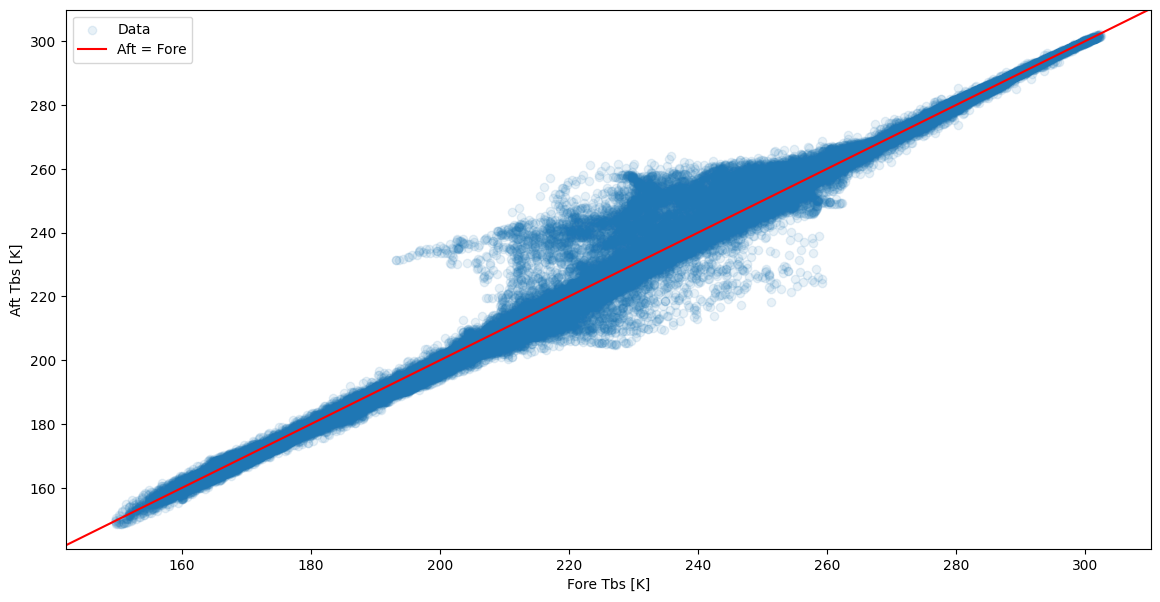

In [5]:
fig, ax = plt.subplots(1,1,figsize = (14,7))

ax.scatter(x = fore.values.flatten(), y = aft.values.flatten(), alpha = 0.1, label="Data")
xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.axline((0,0), slope= 1, color = "Red", label="Aft = Fore")

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel("Fore Tbs [K]")
ax.set_ylabel("Aft Tbs [K]")

ax.legend()


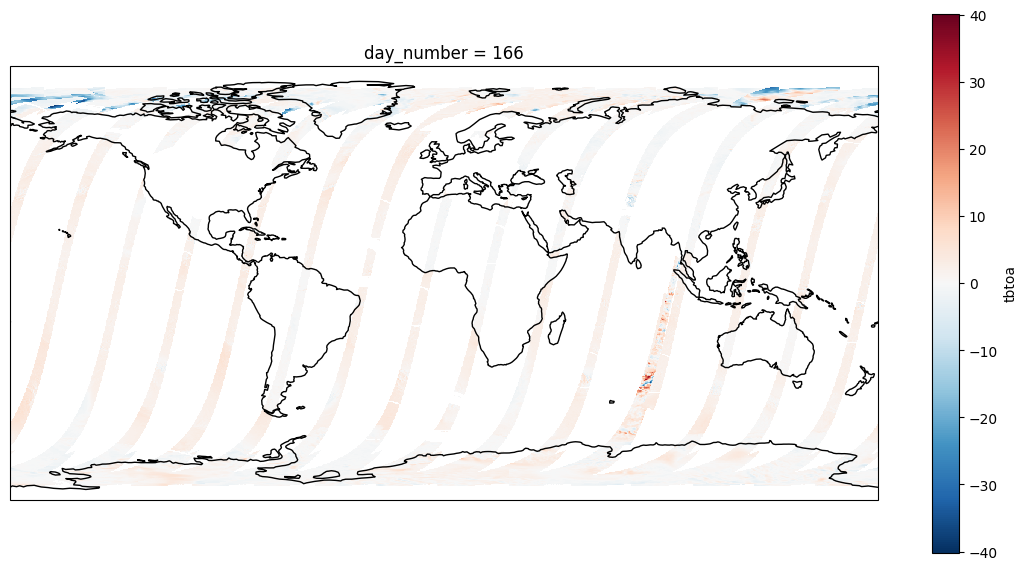

In [6]:
# See the difference in the map:
fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw={"projection": ccrs.PlateCarree()})

diff = fore - aft
diff.plot()
ax.coastlines("110m")

### Tbs over the ocean might have some glint due to the sun which we dont want,

### Also we should filter Tbs over 2ºC

In [7]:
# Landmask
landmask = create_landmask(lon = Tbs.lon, lat= Tbs.lat)
Tbs["landmask"] = (("lat","lon"),landmask.values)

# Tbs = Tbs.where(Tbs.landmask.values == 0)

# Remove values below 2ºC
Tbs = Tbs.where(Tbs > (273.15 + 2))

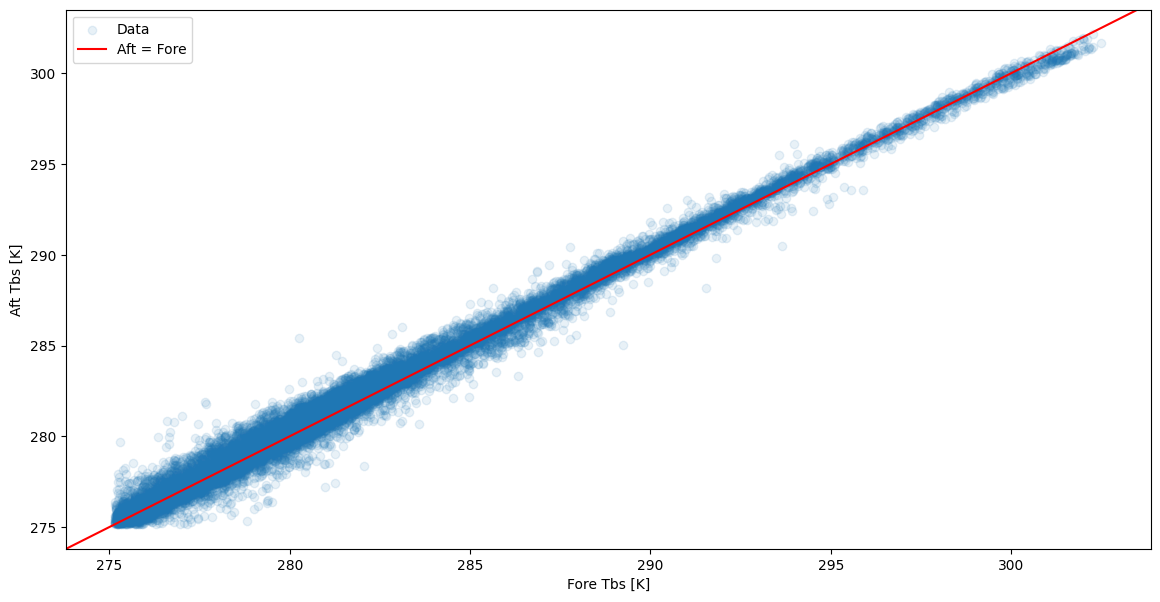

In [8]:
# Lets start with values for one day only
dn = ds.day_number.values[10]

# And one specific frequency and swath:
selection_kw = {
    "polarization" : 0,
    "frequency_band" : 1,
    "swath_sector" : 1,
    "day_number": dn
}

fore = Tbs.sel(**selection_kw, look_direction = 0).where(Tbs.landmask == 0)
aft = Tbs.sel(**selection_kw, look_direction = 1).where(Tbs.landmask == 0)

# Scatterplot
fig, ax = plt.subplots(1,1,figsize = (14,7))

ax.scatter(x = fore.values.flatten(), y = aft.values.flatten(), alpha = 0.1, label="Data")
xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.axline((0,0), slope= 1, color = "Red", label="Aft = Fore")

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel("Fore Tbs [K]")
ax.set_ylabel("Aft Tbs [K]")

ax.legend()

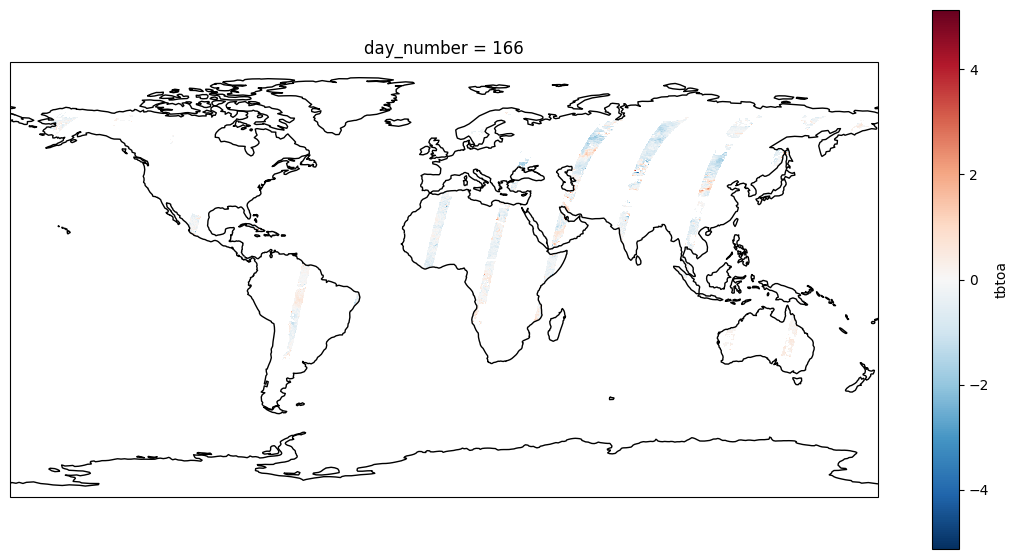

In [9]:
# See the difference in the map:
fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw={"projection": ccrs.PlateCarree()})

diff = fore - aft
diff.plot()
ax.coastlines("110m")

In [10]:
# Fit a regression line between fore and aft

# Linear Reg does not take nan values:

""" 
    Transform the dataset into pd.DataFrame
    Inner join Fore and Aft (by lat-lon multi index)
    Drop Nans if any
"""

fore_df = fore.to_dataframe().dropna()
aft_df = aft.to_dataframe().dropna()

forevaft_df = fore_df.merge(aft_df, how="inner", suffixes=("_fore","_aft"), right_index=True, left_index=True) 
forevaft_df

day_number_fore  landmask_fore  tbtoa_fore  day_number_aft  \
lat     lon                                                                   
-33.375 294.625              166            0.0  275.410004             166   
-33.125 293.125              166            0.0  276.037476             166   
        293.375              166            0.0  277.407501             166   
-32.875 141.375              166            0.0  276.065002             166   
        141.625              166            0.0  276.017487             166   
...                          ...            ...         ...             ...   
 69.375 25.375               166            0.0  277.277496             166   
        25.625               166            0.0  277.364990             166   
        25.875               166            0.0  276.709991             166   
        26.125               166            0.0  275.794983             166   
        26.375               166            0.0  275.157501             166   

                 landmask_aft   tbtoa_aft  
lat     lon                                
-33.375 294.625           0.0  276.372498  
-33.125 293.125           0.0  276.007507  
        293.375           0.0  277.797485  
-32.875 141.375           0.0  275.552490  
        141.625           0.0  275.617493  
...                       ...         ...  
 69.375 25.375            0.0  277.197510  
        25.625            0.0  277.092499  
        25.875            0.0  276.497498  
        26.125            0.0  275.795013  
        26.375            0.0  275.167511  

[19799 rows x 6 columns]

In [11]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

X=forevaft_df["tbtoa_aft"].values.reshape(-1, 1)
y=forevaft_df["tbtoa_fore"].values

reg.fit(X, y)

# Evaluate the model
linear_score = reg.score(X, y)
print("Model score:", linear_score)
print(reg.intercept_, reg.coef_)

Model score: 0.9896267709441084
1.4212646 [0.9941964]


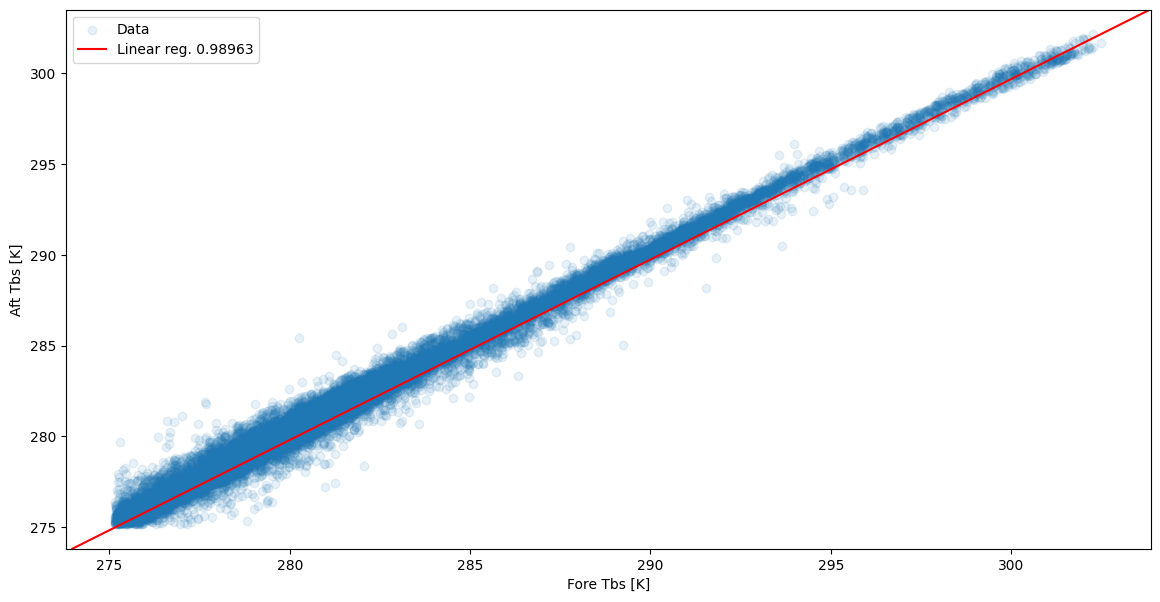

In [12]:
# Plot the regression:
fig, ax = plt.subplots(1,1,figsize = (14,7))

ax.scatter(x = fore.values.flatten(), y = aft.values.flatten(), alpha = 0.1, label="Data")
xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.axline((0,reg.intercept_), slope= reg.coef_[0], color = "Red", label=f"Linear reg. {linear_score:.5f}")

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel("Fore Tbs [K]")
ax.set_ylabel("Aft Tbs [K]")

ax.legend()

### This looks like it could be improved using a plynomial fit of degree 2

In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
degree = 2
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

model.fit(X,y)

# Evaluate the model
polynomial_score = model.score(X, y)
print("Model score:", polynomial_score)

# Get the coefficients and intercept
intercept = model.named_steps['linearregression'].intercept_
coefficients = model.named_steps['linearregression'].coef_

print("Intercept:", intercept)
print("Coefficients:", coefficients)

Model score: 0.9901466350152509
Intercept: 266.96585
Coefficients: [ 0.         -0.86501646  0.00325267]


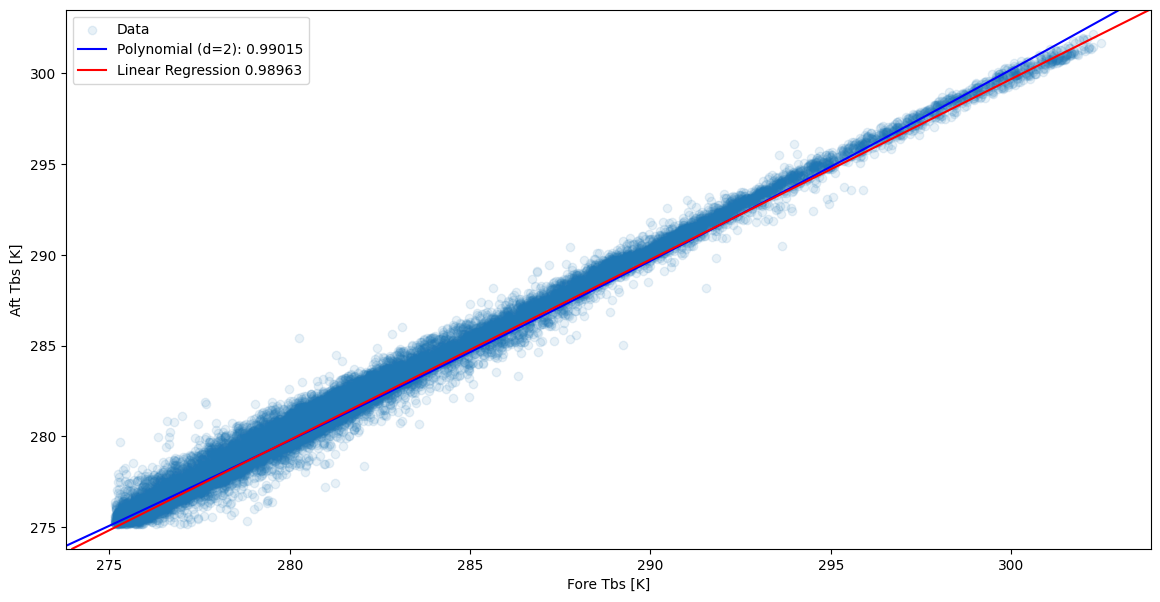

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the regression:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

# Scatter plot of the original data
ax.scatter(x=fore.values.flatten(), y=aft.values.flatten(), alpha=0.1, label="Data")
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Generate a range of x-values for plotting the polynomial regression line
x_range = np.linspace(xlim[0], xlim[1], 500).reshape(-1, 1)

# Predict y-values using the polynomial regression model
y_pred = model.predict(x_range)

# Plot the polynomial regression line
ax.plot(x_range, y_pred, color='Blue', label=f"Polynomial (d={degree}): {polynomial_score:.5f}")

# Plot the original linear regression line for comparison
ax.axline((0, reg.intercept_), slope=reg.coef_[0], color="Red", label=f"Linear Regression {linear_score:.5f}")

# Restore the original limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Labels and legend
ax.set_xlabel("Fore Tbs [K]")
ax.set_ylabel("Aft Tbs [K]")
ax.legend()

plt.show()


In [15]:
# Linear Regression score (R^2)
linear_score = reg.score(X, y)
print("Linear Regression R^2 score:", linear_score)

# Polynomial Regression score (R^2)
polynomial_score = model.score(X, y)
print("Polynomial Regression R^2 score:", polynomial_score)


Linear Regression R^2 score: 0.9896267709441084
Polynomial Regression R^2 score: 0.9901466350152509


### With the full dataset.

Plotting a scatterplot of the whole dataset is unfeasable, but we can still fit regression models.

In [16]:
# Now for all days, swaths, polarizations and frequencies:
fore = Tbs.sel(look_direction = 0).where(Tbs.landmask == 0).drop_vars("landmask")
aft = Tbs.sel(look_direction = 1).where(Tbs.landmask == 0).drop_vars("landmask")

In [17]:
fore_df = fore.to_dataframe()
aft_df = aft.to_dataframe()

In [18]:
# Process each dataframe. dropna, inner join
fore_df = fore_df.dropna()
aft_df = aft_df.dropna()

In [19]:
forevaft_df = fore_df.merge(aft_df, how="inner", suffixes=("_fore","_aft"), right_index=True, left_index=True) 
forevaft_df

tbtoa_fore  \
day_number polarization frequency_band lat     lon     swath_sector               
1          0            0              -48.625 291.875 1             275.877502   
                                               292.125 1             276.602478   
                                               292.375 1             275.524994   
                                       -48.375 291.875 1             275.762482   
                                               292.125 1             276.264984   
...                                                                         ...   
349        1            1               24.375 261.625 1             276.320007   
                                               261.875 1             276.867493   
                                        24.625 80.625  0             275.299988   
                                               261.625 1             275.709991   
                                               261.875 1             275.937500   

                                                                      tbtoa_aft  
day_number polarization frequency_band lat     lon     swath_sector              
1          0            0              -48.625 291.875 1             275.734985  
                                               292.125 1             276.429993  
                                               292.375 1             276.774994  
                                       -48.375 291.875 1             275.422485  
                                               292.125 1             276.005005  
...                                                                         ...  
349        1            1               24.375 261.625 1             277.162476  
                                               261.875 1             277.402496  
                                        24.625 80.625  0             275.417480  
                                               261.625 1             276.875000  
                                               261.875 1             276.677490  

[1488873 rows x 2 columns]

In [20]:
# Linear and polynomial reg.
X=forevaft_df["tbtoa_aft"].values.reshape(-1, 1)
y=forevaft_df["tbtoa_fore"].values

linear_reg = LinearRegression()
degree = 3
model = model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

linear_reg.fit(X,y)
model.fit(X,y)

# Linear Regression score (R^2)
linear_score = reg.score(X, y)
print("Linear Regression R^2 score:", linear_score)

# Polynomial Regression score (R^2)
polynomial_score = model.score(X, y)
print("Polynomial Regression R^2 score:", polynomial_score)


Linear Regression R^2 score: 0.9867644599990402
Polynomial Regression R^2 score: 0.9872954843147241


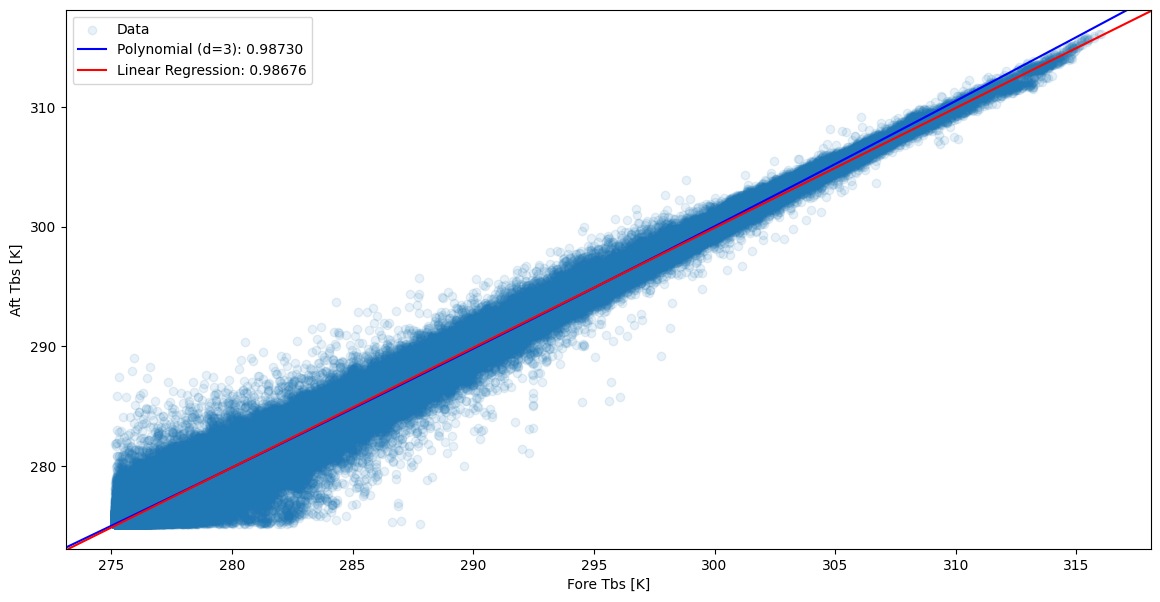

In [21]:
# Can I plot this ? 

# Plot the regression:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

# Scatter plot of the original data
ax.scatter(x=X, y=y, alpha=0.1, label="Data")
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Generate a range of x-values for plotting the polynomial regression line
x_range = np.linspace(xlim[0], xlim[1], 500).reshape(-1, 1)

# Predict y-values using the polynomial regression model
y_pred = model.predict(x_range)

# Plot the polynomial regression line
ax.plot(x_range, y_pred, color='Blue', label=f"Polynomial (d={degree}): {polynomial_score:.5f}")

# Plot the original linear regression line for comparison
ax.axline((0, linear_reg.intercept_), slope=linear_reg.coef_[0], color="Red", label=f"Linear Regression: {linear_score:.5f}")

# Restore the original limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Labels and legend
ax.set_xlabel("Fore Tbs [K]")
ax.set_ylabel("Aft Tbs [K]")
ax.legend()

plt.show()

### This data representation if missleading, the color does not accurately represent the density of points

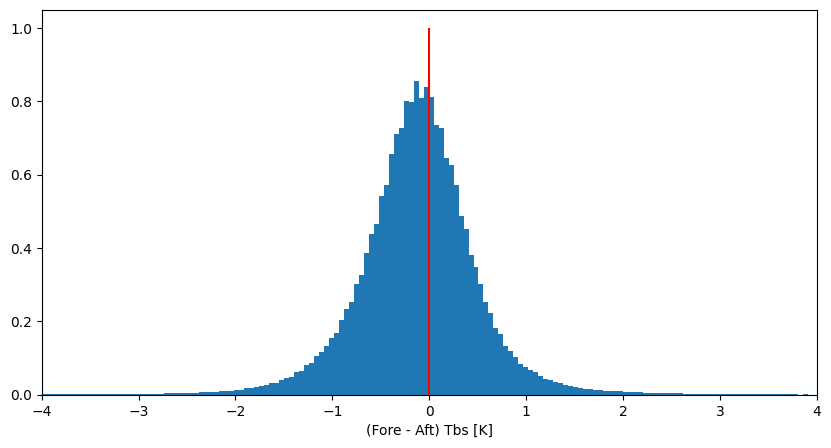

In [22]:
# Histogram of Fore - aft instead
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.hist(x = forevaft_df["tbtoa_fore"] - forevaft_df["tbtoa_aft"], bins = 500, density= True)

ax.set_xlim([-4,4])
ax.set_xlabel("(Fore - Aft) Tbs [K]")

ax.vlines(x = 0, ymin = 0, ymax = 1, color = "Red")
plt.show()


With the simple linear model we can impute missing values with reasonable accuracy (~ 2K) over the US with a simple linear model

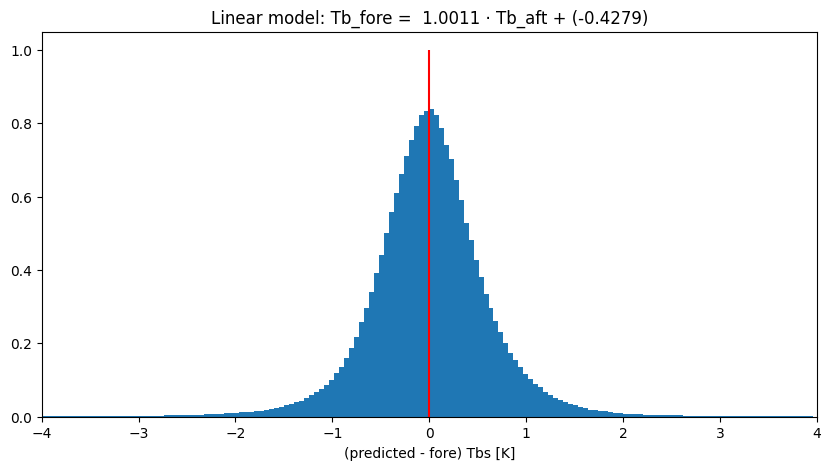

In [23]:
# Predict with the linear model
linear_predictions = linear_reg.predict(X)

# Histogram of Fore - aft instead
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.hist(x = linear_predictions - forevaft_df["tbtoa_fore"], bins = 500, density= True)

ax.set_xlim([-4,4])
ax.set_xlabel("(predicted - fore) Tbs [K]")
ax.set_title(f"Linear model: Tb_fore =  {linear_reg.coef_[0]:.4f} · Tb_aft + ({linear_reg.intercept_:.4f})")
ax.vlines(x = 0, ymin = 0, ymax = 1, color = "Red")
plt.show()

In [24]:
# MSE of the linear model Tb_fore = LM( Tb_aft )
from sklearn.metrics import mean_squared_error

mse_linear = mean_squared_error(y, linear_predictions)
print("Linear Regression MSE:", mse_linear)


Linear Regression MSE: 0.4251493


In [25]:
# Coeficients:

# Linear model
print("Linear model")
print(reg.intercept_, reg.coef_)
print("\n")

# Get the coefficients and intercept poly fit
intercept = model.named_steps['linearregression'].intercept_
coefficients = model.named_steps['linearregression'].coef_
print(f"Poly fit D = {degree}")
print("Intercept:", intercept)
print("Coefficients:", coefficients)

Linear model
1.4212646 [0.9941964]


Poly fit D = 3
Intercept: 147.64323
Coefficients: [ 0.0000000e+00 -1.4617714e-01  2.6060522e-03 -1.4188843e-06]
